# Доклад
## Епифанов Артём Михайлович, БПМИ 2210

## Обзор библиотеки Dask

In [1]:
# %pip install numpy
# %pip install pandas
# %pip install scikit-learn
# %pip install dask
# %pip install plotly-express
# %pip install dask-ml
# %pip install graphviz
# %pip install pyarrow
# %pip install bokeh

In [2]:
import numpy as np
import pandas as pd
import sklearn.model_selection
import sklearn.linear_model
import sklearn.metrics
import dask
import dask.array as da
import dask.dataframe as dd
import plotly.express as px
import dask_ml.model_selection
import dask_ml.linear_model
from dask.distributed import Client, LocalCluster
import glob
from time import sleep

# Информацию о кластере Вы сможете увидеть в разделе 3 доклада

# Создание локального кластера
cluster = LocalCluster(scheduler_port=9200)

# # Подключение клиента к кластеру
client = Client(cluster)

Вы можете перейти по адресу http://localhost:8787/status и посмотреть, что там происходит. В разделе 3 будут пояснения

## Отличительные черты Dask

**1. Основное назначение:**

Предназначен для работы с очень большими датасетами, которые не умещаются в оперативной памяти, путем их разбиения на меньшие части.

<br>

**2. Ленивые вычисления:**

Использует ленивые вычисления, т. е. операции создают граф вычислений, который может быть выполнен позже, а не непосредственно после вызова операции.

<br>

**3. Параллелизм:**

Может автоматически параллелить вычисления и оптимизировать выполнение задач на всех доступных ядрах компьютера.

<br>

**4. Интерфейс:**

Очень похож на Pandas, что облегчает переход для разработчиков.

<br>

**5. Распределённые вычисления:**

Поддерживает распределенные вычисления с использованием Dask Distributed, позволяя выполнять операции на кластере.

<br>

**6. Оптимизация:**

Оптимизирует граф вычислений перед выполнением для улучшения производительности, минимизируя общее количество вычислений и передачу данных.

# 1. Dask Array

Проверим выделение памяти на массивы

```test = np.ones((1000000, 1000, 1000))``` - память на такой объект выделить не получится

Но с Dask происходит магия!

In [3]:
test = da.ones((1000000, 1000, 1000))
display(test)

dask.array<ones_like, shape=(1000000, 1000, 1000), dtype=float64, chunksize=(255, 255, 255), chunktype=numpy.ndarray>

В этом примере ```da.ones((1000000, 1000, 1000))``` - массив, который в теории содержит миллиарды элементов, но фактические данные не генерируются и не занимают память, пока не будут запрошены какие-либо вычислительные операции. Это позволяет работать с массивами, которые намного превышают объём доступной памяти.

Согласно документации, Dask реализует многие функции из numpy и pandas, но делает это эффективно, с использованием графов вычислений.

# Что такое граф вычислений?

**Граф вычислений** — это направленный ациклический граф (DAG), в котором узлы представляют вычислительные операции или данные, а рёбра указывают на зависимости между этими операциями. То есть каждый узел графа представляет операцию (например, сложение, фильтрация, агрегация), а рёбра отражают поток данных между этими операциями.

dask.array<random_sample, shape=(50, 2), dtype=float64, chunksize=(10, 1), chunktype=numpy.ndarray>

Среднее = 0.5428340658664496


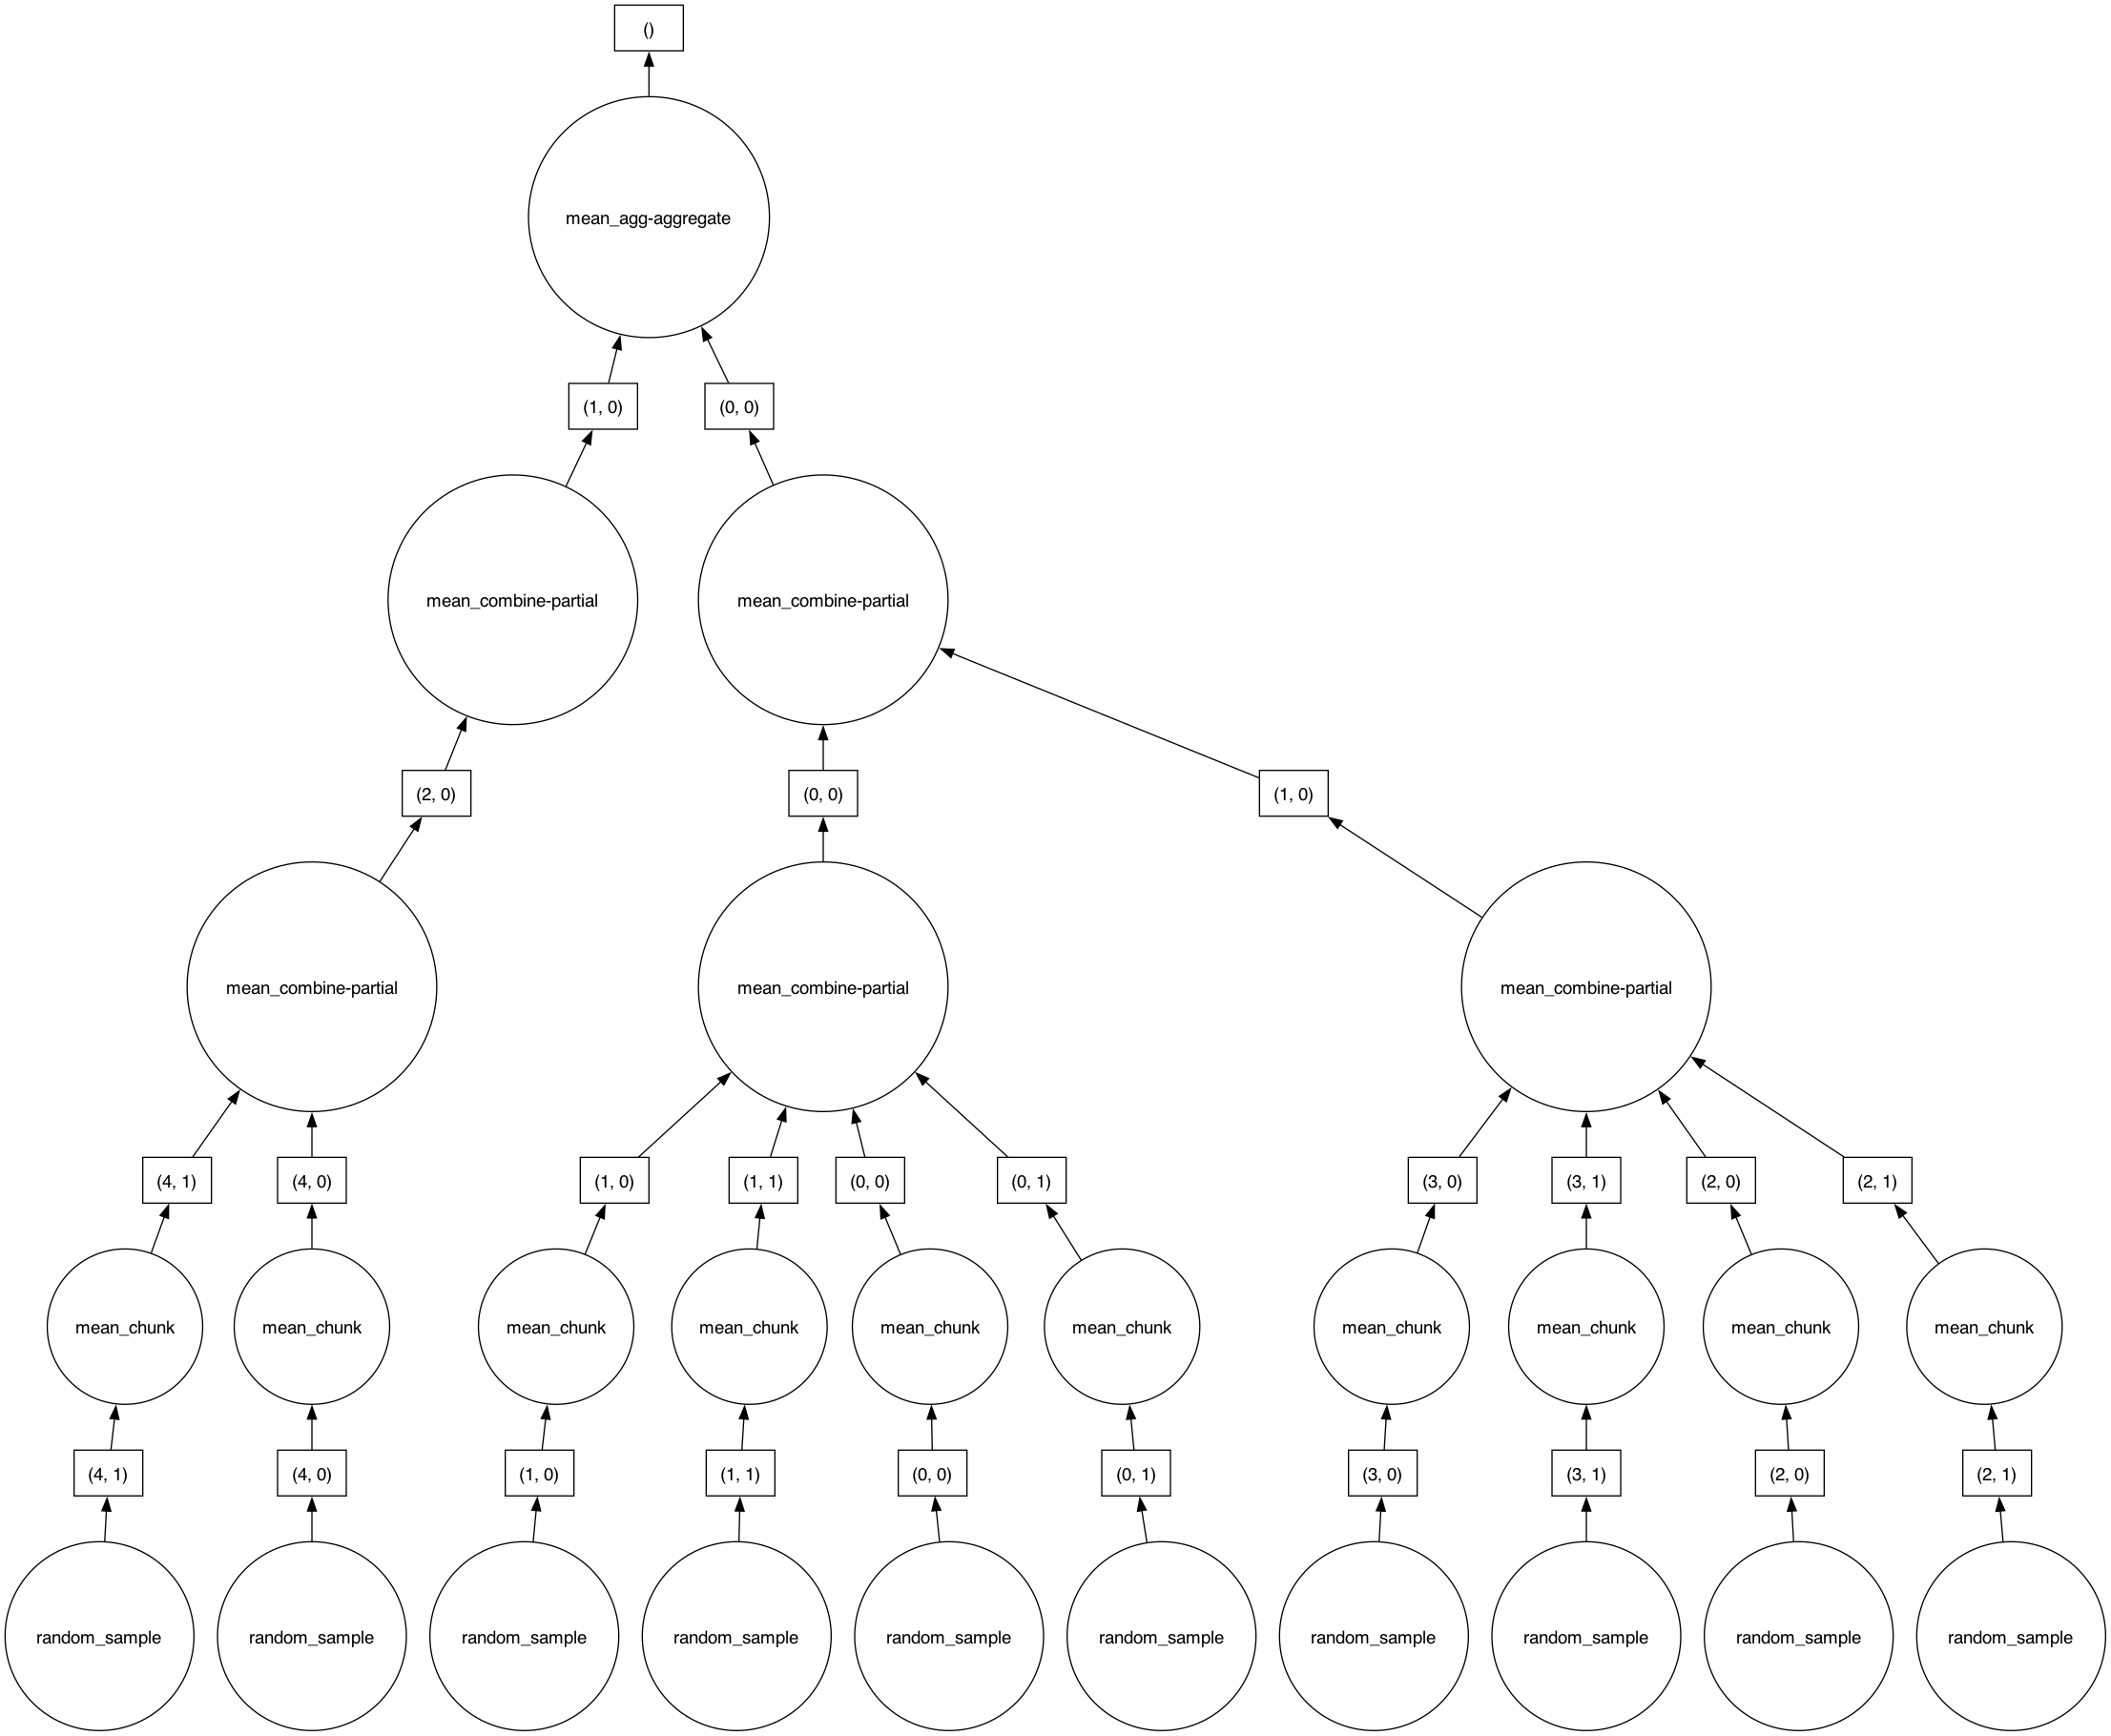

In [4]:
test_mean = da.random.random((50, 2), chunks=(10, 1),)

display(test_mean)

# Лениво вычисляем среднее
mean_value = test_mean.mean()

# По графу вычислений считаем среднее
print(f'Среднее = {mean_value.compute()}') 

# Визуализируем граф вычислений
mean_value.visualize()

В этом примере мы вычисляем сначала среднее для каждого чанка в ```mean_chunk``` (в каждом начальном чанке у нас 10 элементов), и затем последовательно эти значения собираюся в чанки ```mean_combine-partial```, которые в самом конце (верхушка графа) наконец вычисляются. Все операции происходят параллельно, и за счёт этого на огромных массивах у нас будет преимущество по скорости вычислений!

Более наглядный пример:

In [5]:
def increment(x):
    sleep(1)
    return x + 1

In [6]:
%%time
# Обычная однопоточная работа
tmp = []
for i in range(5):
    tmp.append(increment(i))
print(sum(tmp))

15
CPU times: user 616 ms, sys: 77.8 ms, total: 693 ms
Wall time: 5.02 s


15
CPU times: user 100 ms, sys: 30.4 ms, total: 131 ms
Wall time: 1.33 s


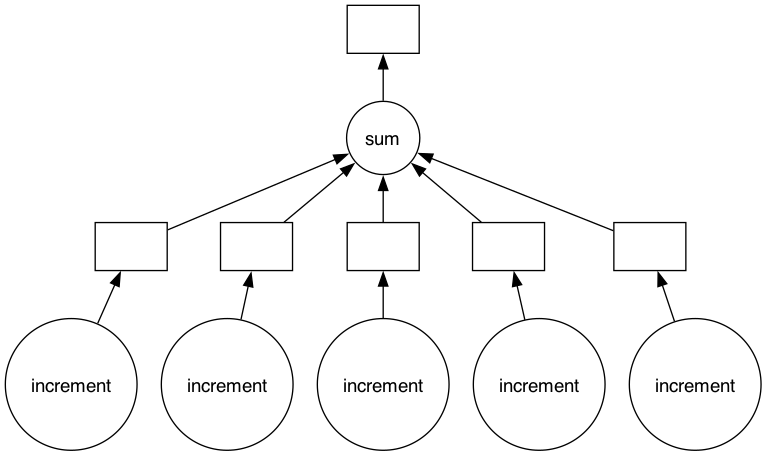

In [7]:
%%time
# Параллельные вычисления c Dask
tmp = []
for i in range(5):
    tmp.append(dask.delayed(increment)(i))
result = dask.delayed(sum)(tmp)
print(result.compute())
result.visualize()

# 2. Dask Dataframe и машинное обучение

Воспользуюсь датасетом с Kaggle о поездках в такси Нью-Йорка:

https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

## I. Считывание файлов

In [8]:
%%time
# Pandas
parquet_files = glob.glob('archive/yellow*.parquet')
dataframes = [pd.read_parquet(file) for file in parquet_files]
df = pd.concat(dataframes, ignore_index=True).dropna().head(2_000_000)

CPU times: user 17.8 s, sys: 14.5 s, total: 32.2 s
Wall time: 1min 3s


In [9]:
%%time
# Dask
ddf = dd.read_parquet('archive/yellow*.parquet', blocksize=64000000).dropna().head(2_000_000)

CPU times: user 138 ms, sys: 266 ms, total: 404 ms
Wall time: 2.17 s


Dask нативно поддерживает glob, что позволяет считать множество файлов всего за одну строку


Также Dask в памяти хранит не сразу весь датафрейм, а лишь его кусочки (на моём компьютере он разбил 36 миллионов строк на 11 датафреймов). За счёт этого мы смогли эффективно извлечь нужные нам 2000000 строк. Размер каждого чанка я сделал равным примерно 64мб (```blocksize=64000000```)

## II Анализ данных

Не советую раскомментировать графики на больших данных! Тетрадка может упасть, но этот пример показывает, что dask dataframe совместим с библиотеками для визуализации.

In [10]:
# %%time
# Pandas
# fig = px.scatter(ddf, x='trip_distance', y='fare_amount')
# fig.show()

In [11]:
# %%time
# Dask  
# fig = px.scatter(ddf, x='trip_distance', y='fare_amount')
# fig.show()

- Отсеиваем ненужные значения:

In [12]:
%%time
df = df[(df.trip_distance != 0) & (df.fare_amount != df.fare_amount.max())]

CPU times: user 247 ms, sys: 382 ms, total: 628 ms
Wall time: 853 ms


In [13]:
%%time
ddf = ddf[(ddf.trip_distance != 0) & (ddf.fare_amount != ddf.fare_amount.max())]

CPU times: user 91.2 ms, sys: 93.3 ms, total: 184 ms
Wall time: 177 ms


## III Предсказание значения

In [14]:
features = ['trip_distance','passenger_count']
target = 'fare_amount'

In [15]:
%%time
p_X_train, p_X_val, p_y_train, p_y_val = sklearn.model_selection.train_test_split(df[features], df[target], test_size=0.3, random_state=21, shuffle=True)
model = sklearn.linear_model.LinearRegression()
model.fit(p_X_train, p_y_train)
p_y_pred=model.predict(p_X_val)
print(f'MAE: {sklearn.metrics.mean_absolute_error(p_y_pred, p_y_val)}')

MAE: 8.497204442269737
CPU times: user 253 ms, sys: 219 ms, total: 473 ms
Wall time: 236 ms


In [16]:
%%time
d_X_train, d_X_val, d_y_train, d_y_val = dask_ml.model_selection.train_test_split(ddf[features].values, ddf[target].values, test_size=0.3, random_state=21, shuffle=True)
model = dask_ml.linear_model.LinearRegression()
print('Fit')
model.fit(d_X_train, d_y_train)
print('Predict')
d_y_pred=model.predict(d_X_val)
print(f'MAE: {sklearn.metrics.mean_absolute_error(d_y_pred, d_y_val)}')

Fit


/Users/amepifanov/Documents/Subjects/Deep_Python/Report/venv/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 42.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Predict
MAE: 1.6750387383986602
CPU times: user 1.13 s, sys: 698 ms, total: 1.83 s
Wall time: 4.62 s


Как можно заметить, Dask работает побыстрее, но его недостатки заключаются в том, что довольно много операций из Pandas у него не распараллеленно - та же сортирвока. Dask скорее подходит для обработки и анализа огромных датасетов. Датасет, который весит сотни гигабайт, я не рискнул найти, но уверен, что он справится гораздо шустрее Pandas.

Но в тоже время, его интерфейс сделан очень удобно и огромное количество вещей, которые люди используют в pandas и numpy, поддерживаются этой библиотекой.

# 3. Распределённые вычисления с помощью кластера 

```x = np.random.random(1_000_000_000)``` <br>
```print(x.mean())``` <br>
Этот код не получится выполнить

Но Dask сможет!

In [17]:
# Создание большого массива с использованием dask.array
x = da.random.random(1_000_000_000, chunks=(1_000_000))
mean_x = x.mean()

# Вычисление результата
result = mean_x.compute()  # Это вызовет распределённое вычисление

print(result)

0.5000105234964588


Код с Numpy не получилось выполнить, а Dask смог за ~3 секунды

## Посмотрим на Dask Dashboard и его основные вкладки

## Status

По адресу, который я писал в начале доклада (http://localhost:8787/status), Вы увидите примерно такую картину
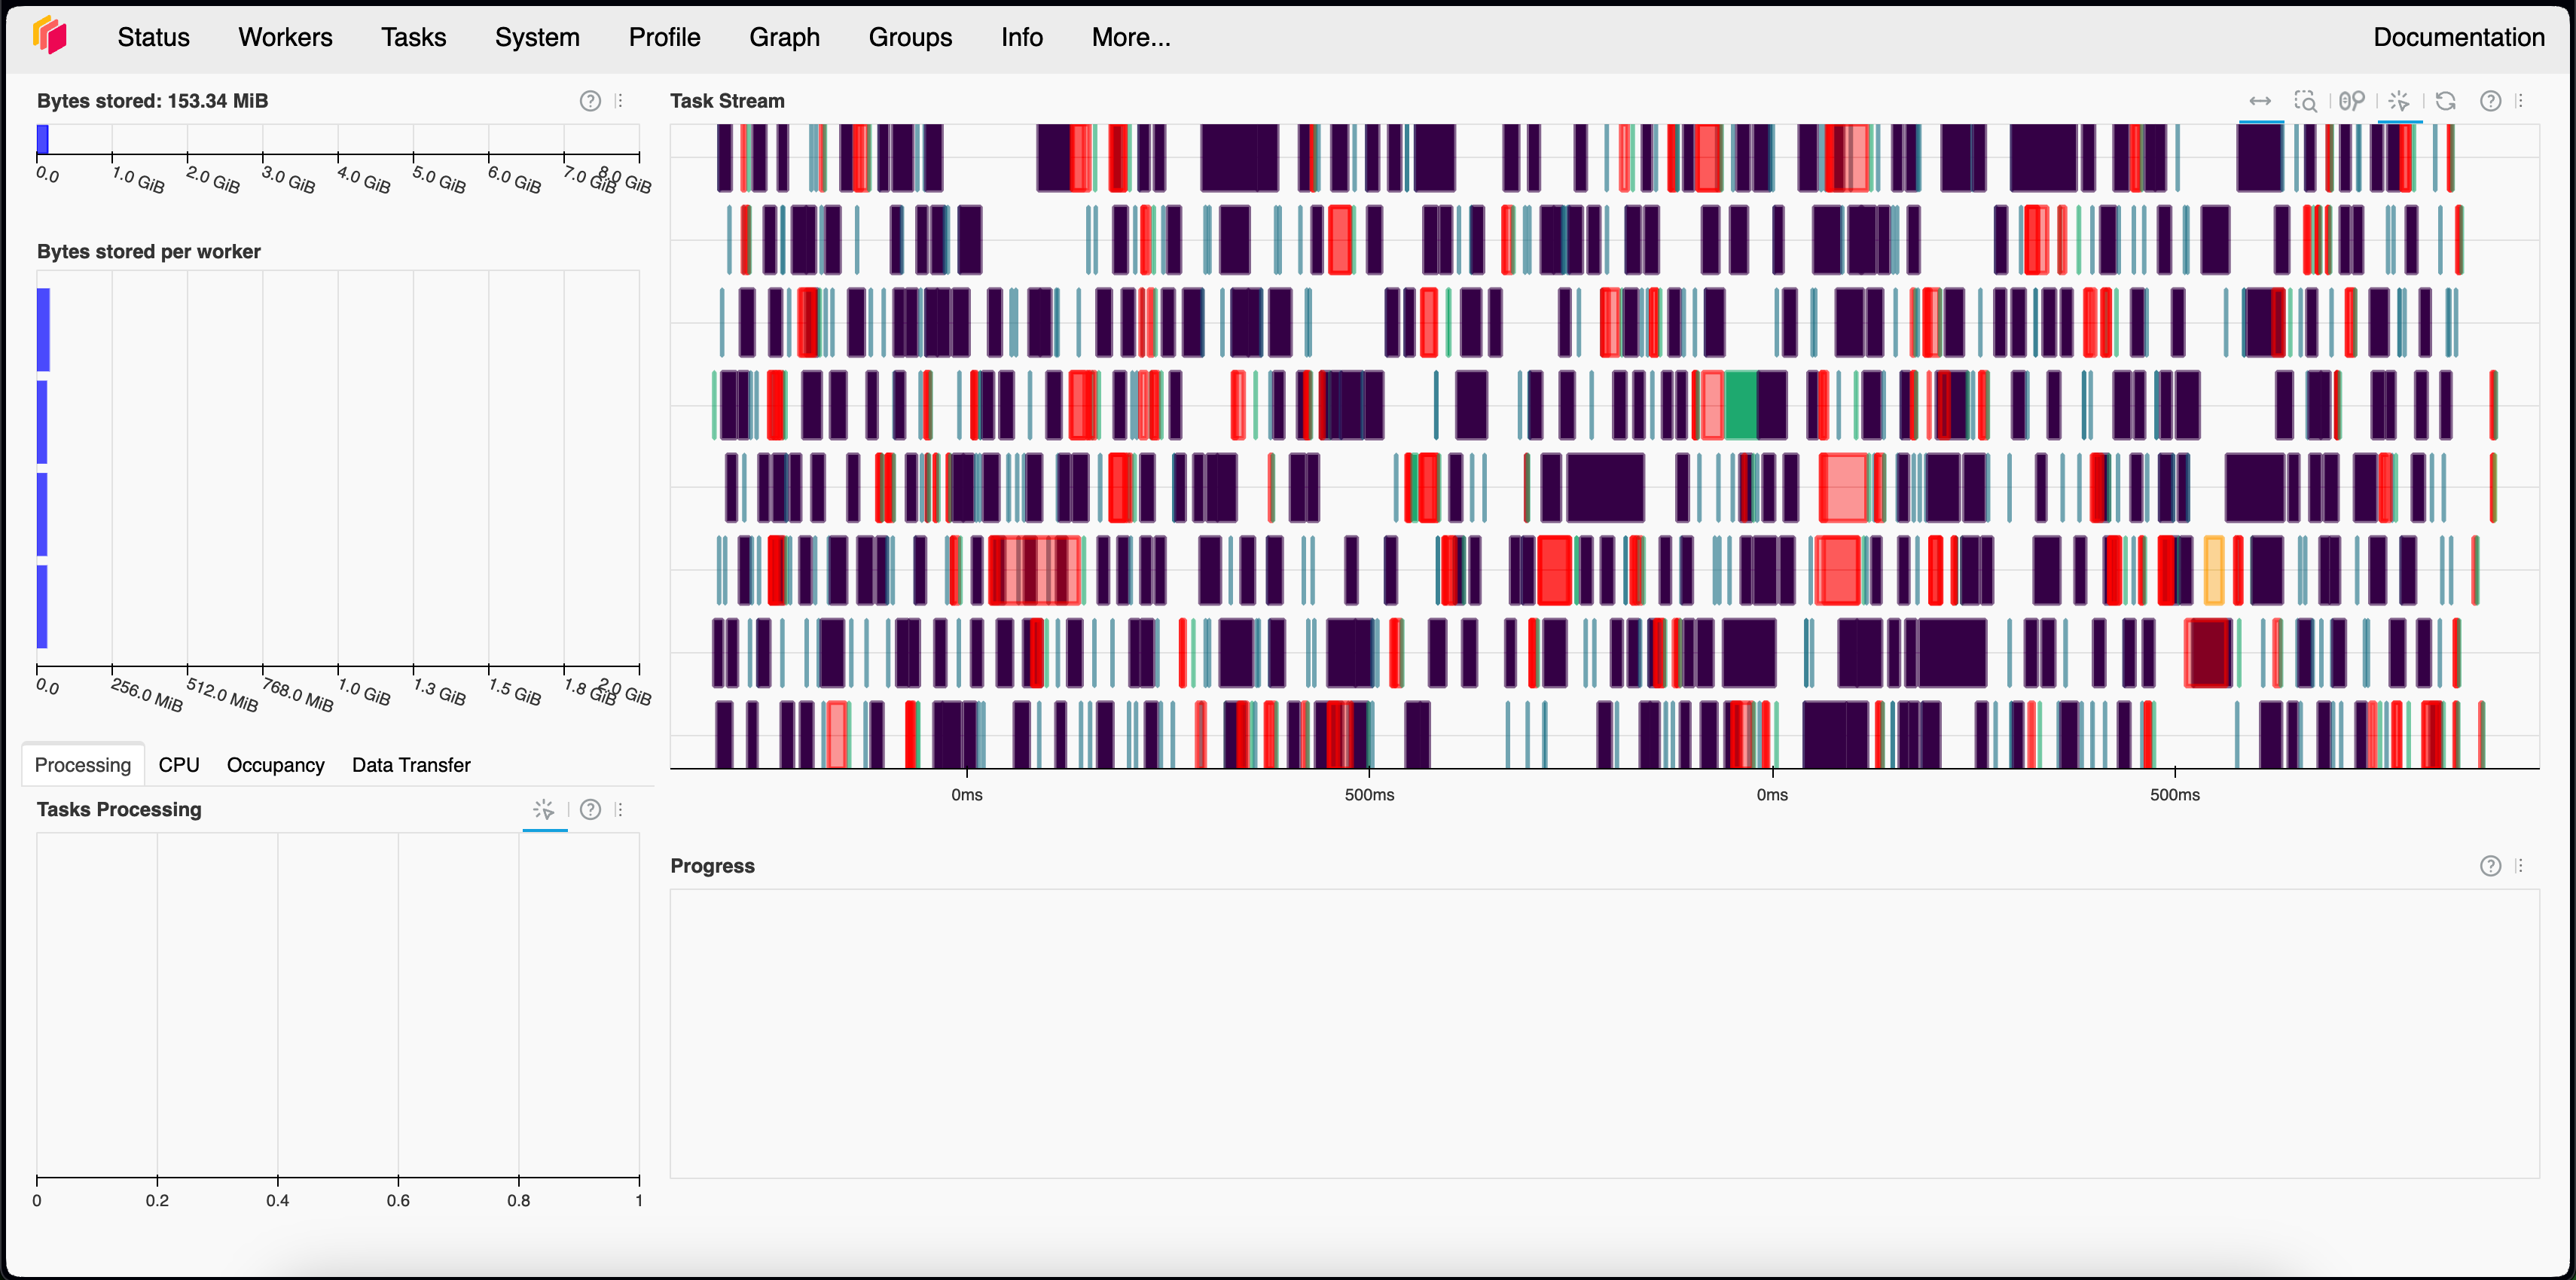

- **Bytes Stored и Bytes per Worker**: Память кластера и Память на одного работника

- **Task Processing/CPU Utilization/Occupancy/Data Transfer**: Задачи, обрабатываемые каждым рабочим/Утилизация процессора на каждого рабочего/Ожидаемое время выполнения всех задач, находящихся в данный момент на рабочем.

- **Task Stream**: Отдельная задача в потоках.

- **Progress**: Выполнение набора задач.

## Workers
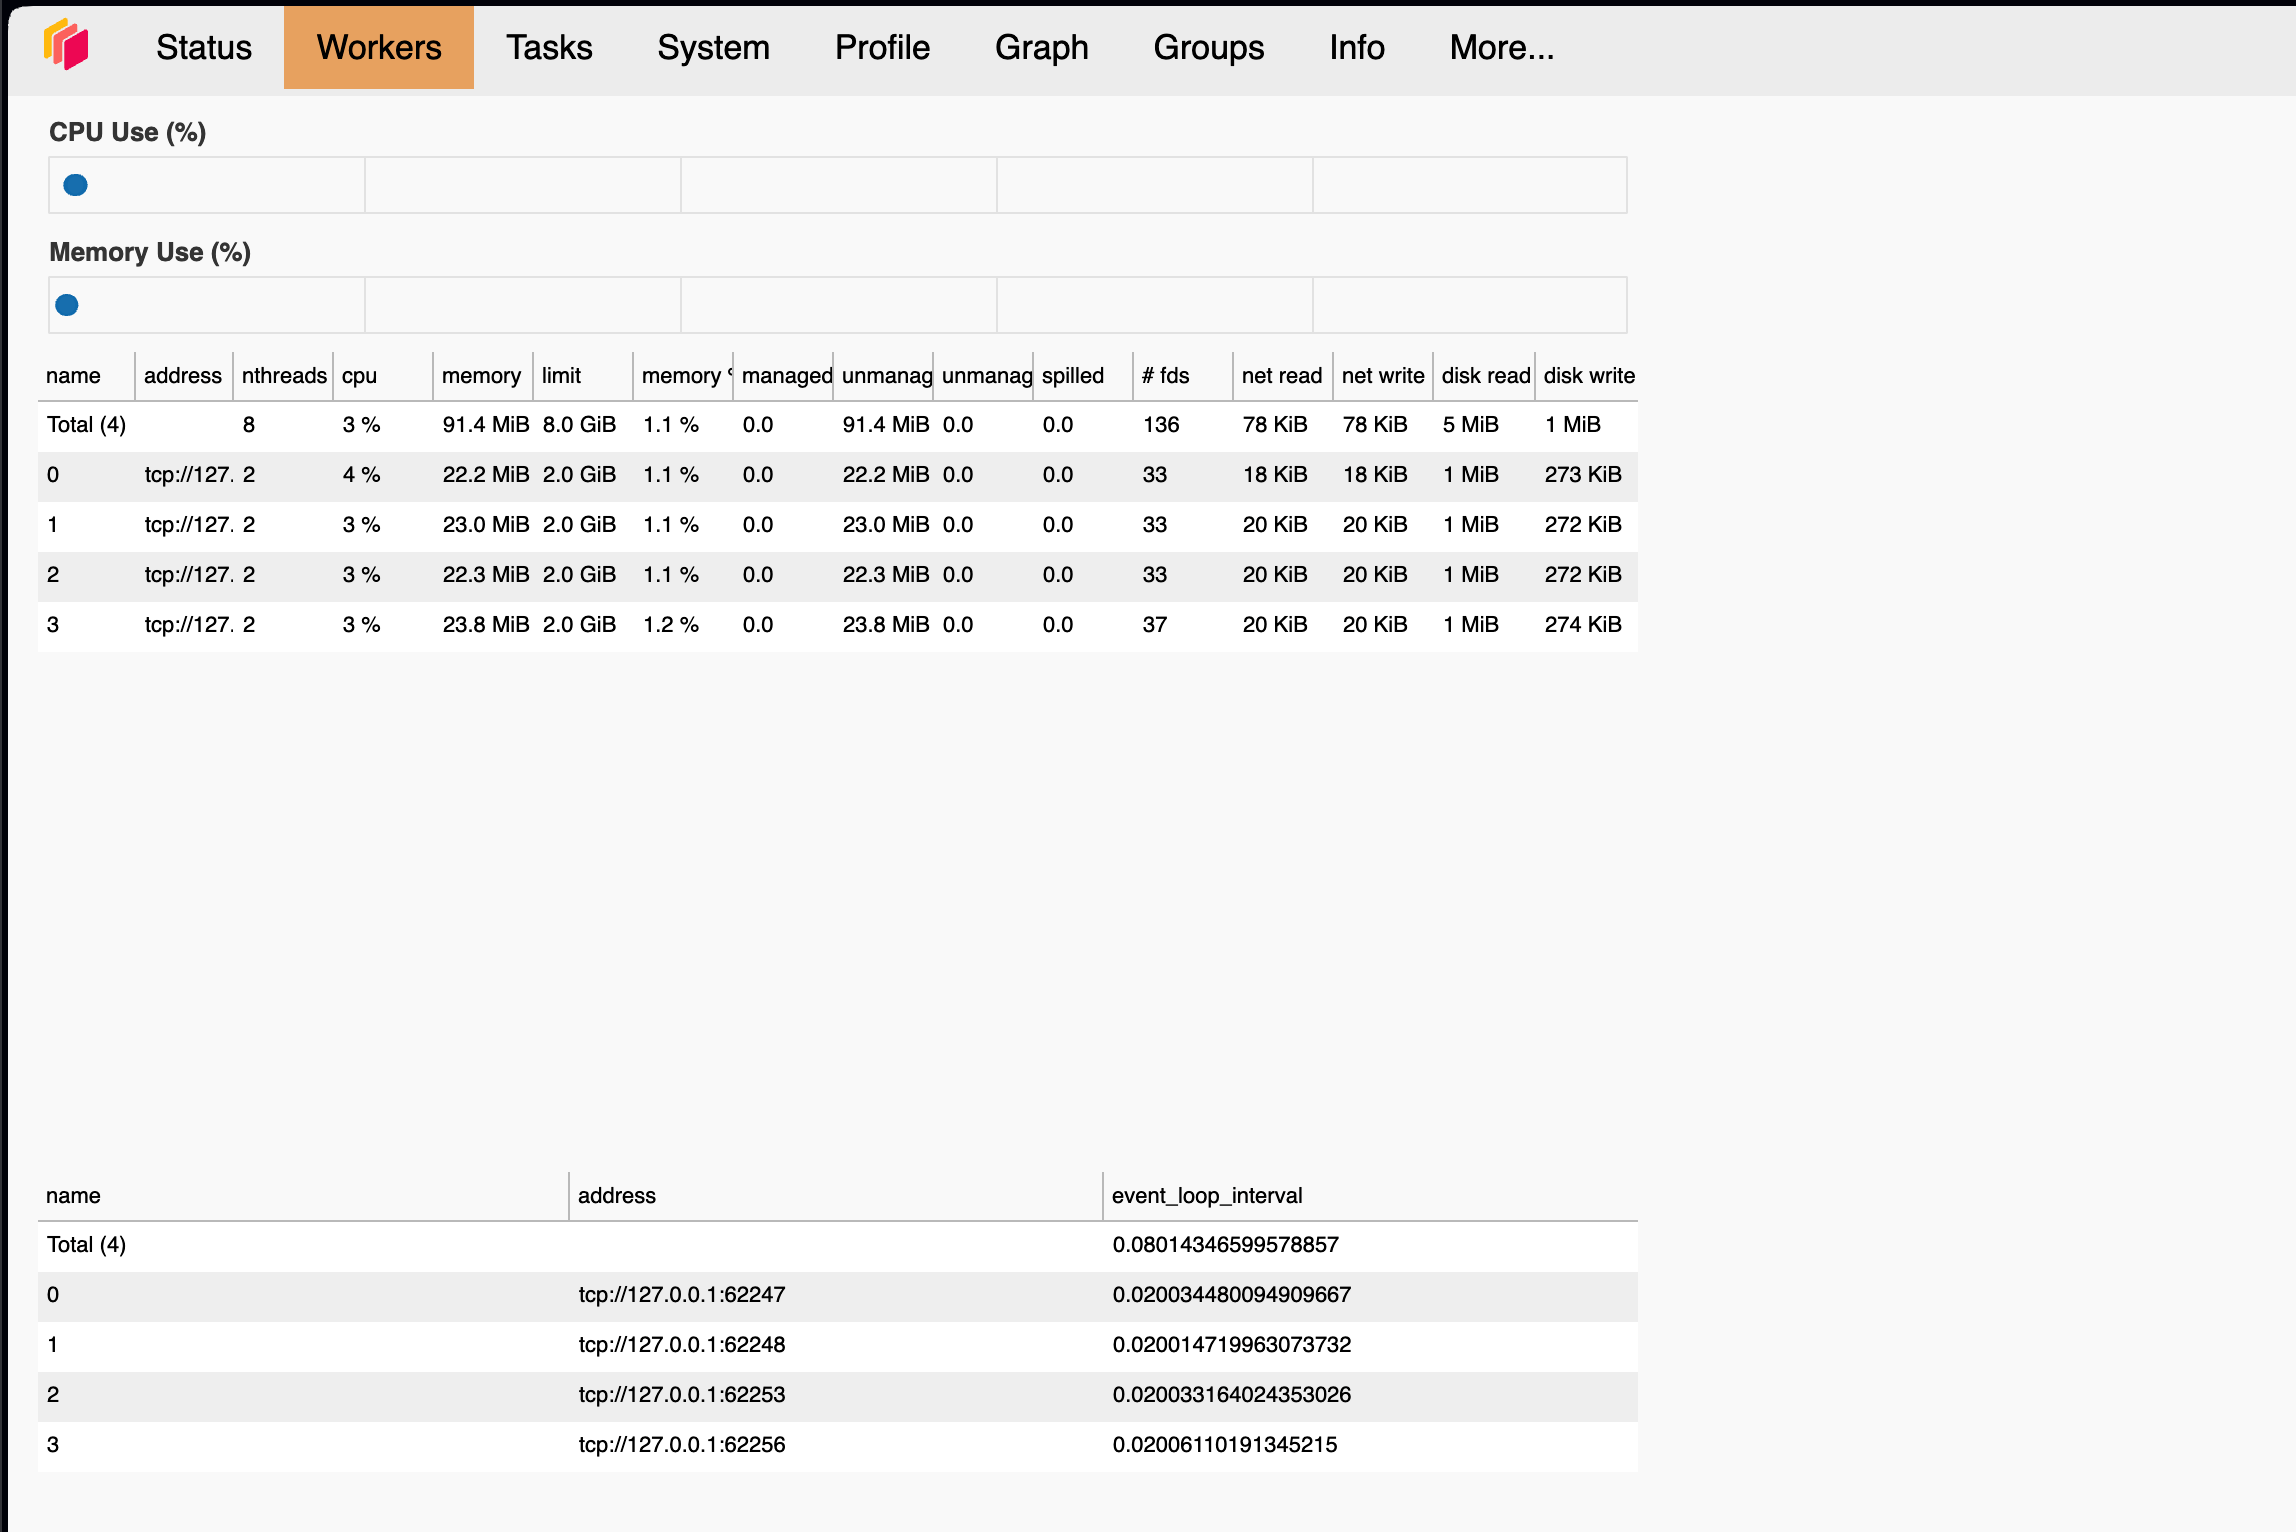

Это вкладка **Workers**, которая предоставляет информацию о состоянии и ресурсах каждого рабочего узла (worker) в кластере Dask <br><br/>

- **CPU Use (%)**: Процентное использование ЦПУ каждым рабочим узлом.

- **Memory Use (%)**: Процентное использование памяти каждым рабочим узлом.

- **Name**: Уникальный идентификатор рабочего узла.

- **Address**: Сетевой адрес рабочего узла.

- **Nthreads**: Количество потоков, доступных каждому рабочему узлу.

- **Memory**: Показывает использование памяти каждым рабочим узлом в мегабайтах.

- **Limit**: Лимит памяти для каждого рабочего узла.

- **Memory %**: Процент использования памяти рабочими узлами от их лимита.

- **Managed**: Объем управляемой памяти (память, используемая Dask для хранения данных).

- **Unmanaged**: Объем неуправляемой памяти (память, используемая не Dask, а самим Python или другими процессами).

- **Spilled**: Объем данных, "пролитых" на диск из-за нехватки оперативной памяти.

- **Fds**: Количество открытых файловых дескрипторов.

- **Read/Write**: Статистика сетевого ввода/вывода (сколько данных было прочитано и записано по сети).

- **Disk Read/Write**: Статистика ввода/вывода на диске (сколько данных было прочитано и записано на диск).

Если Вы зайдёте в Tasks, то увидите примерно это:
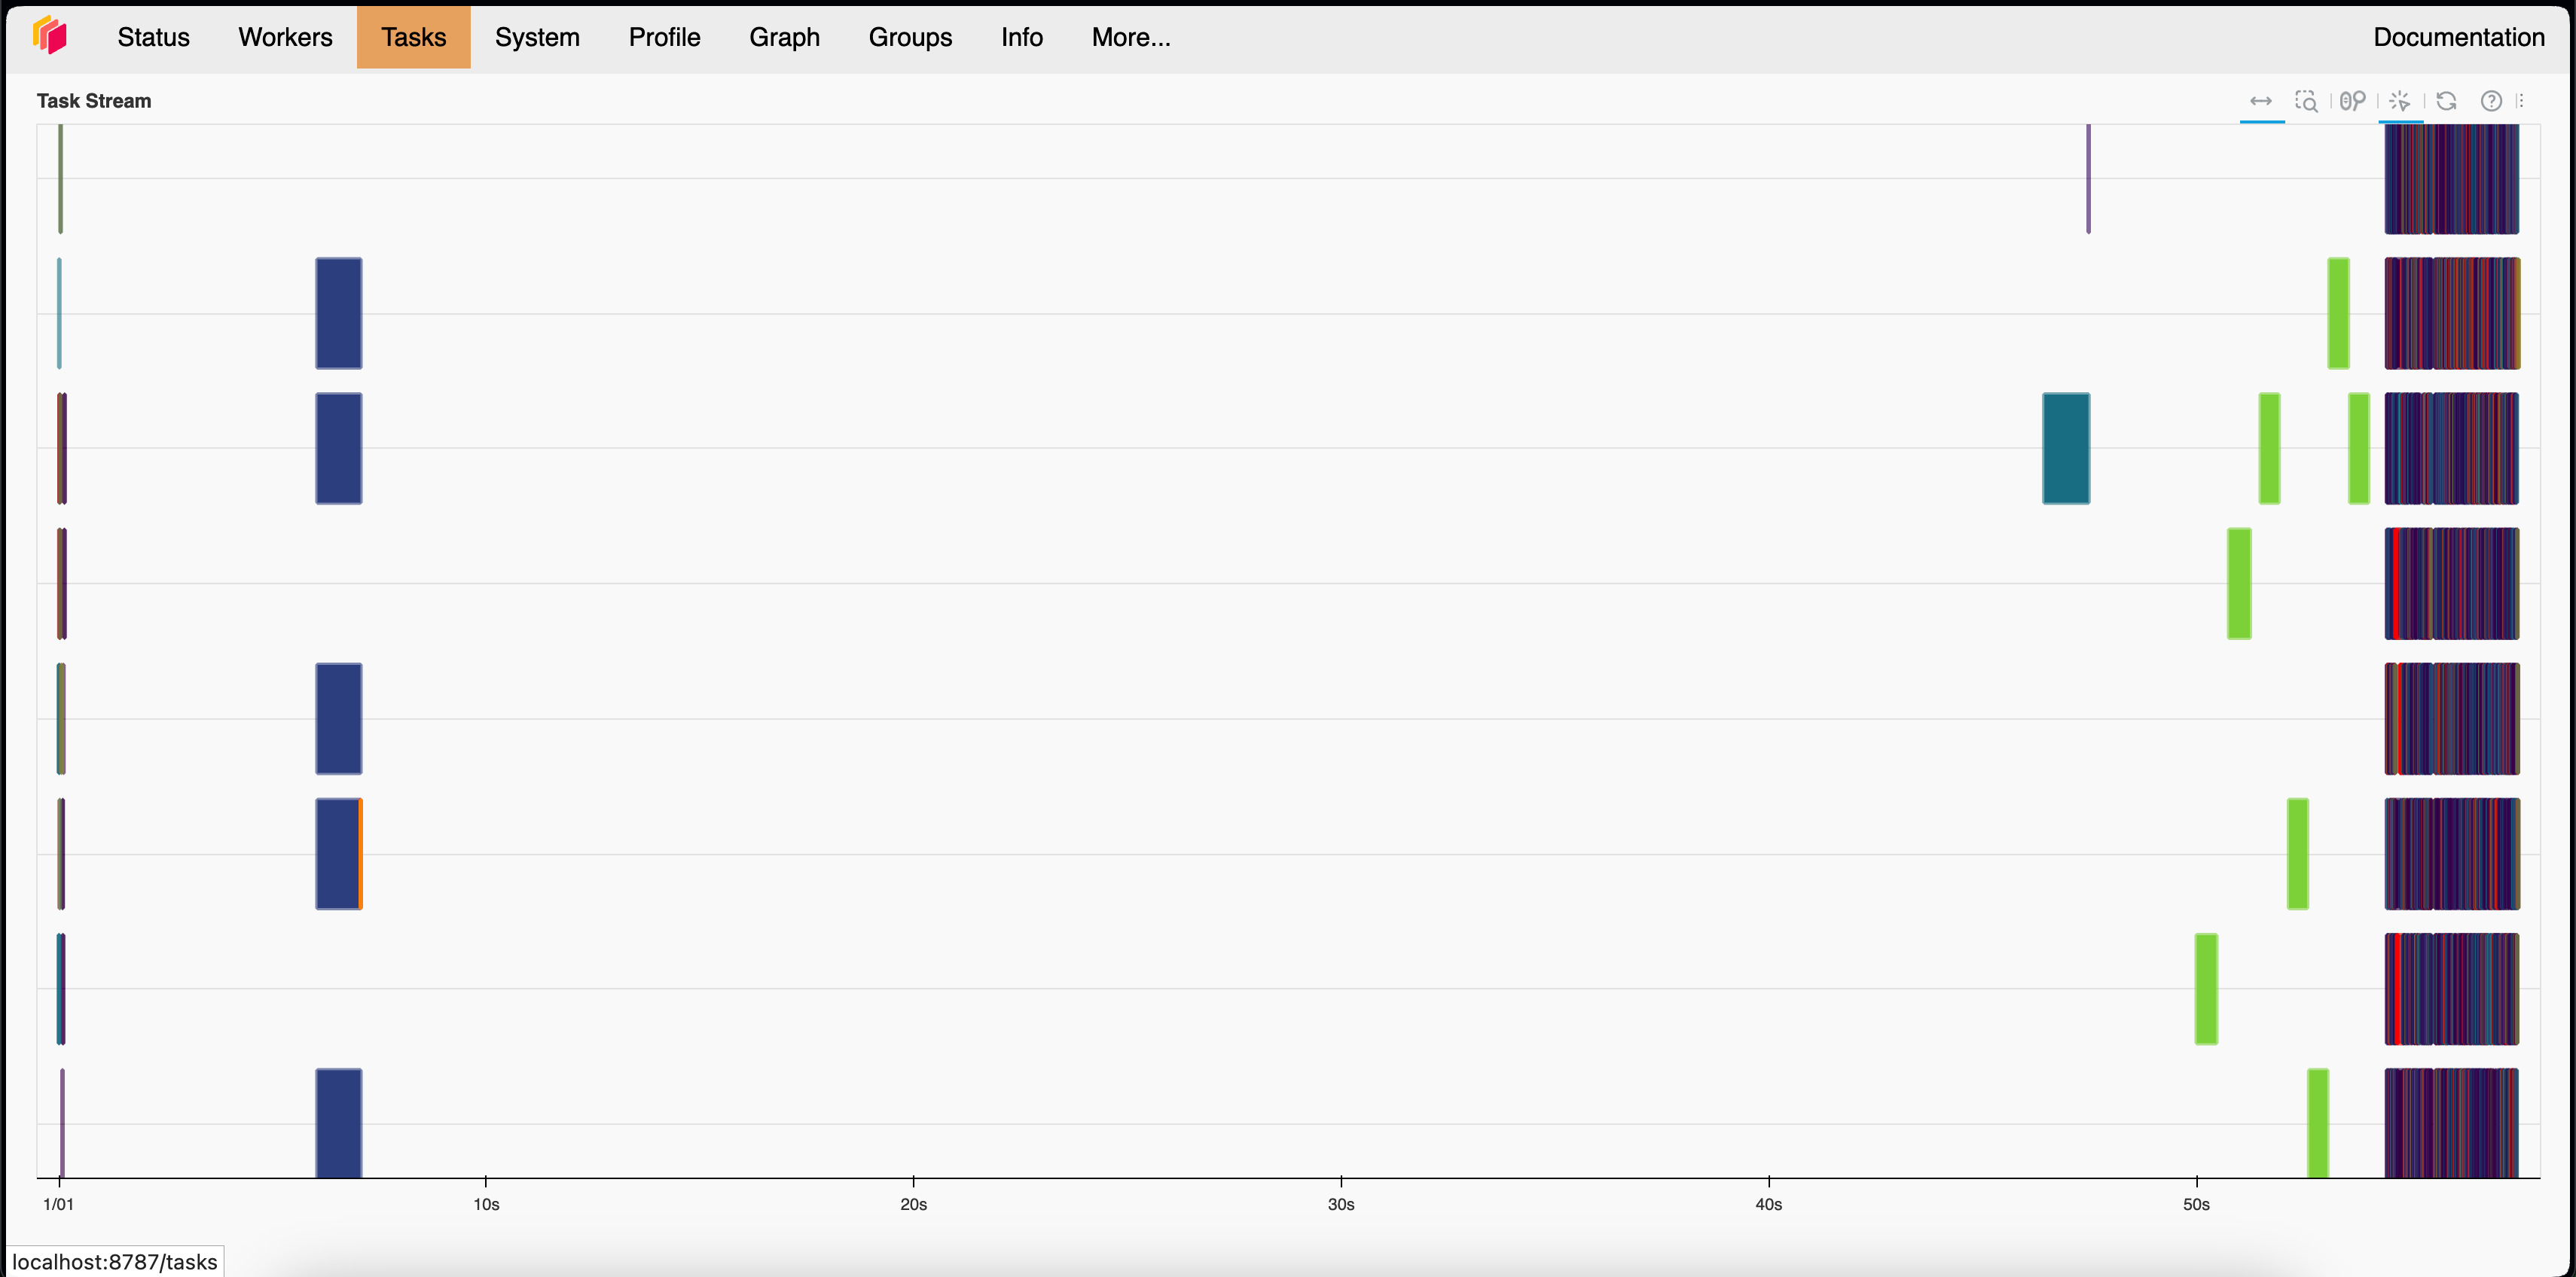


Это **Task Stream**, который представляет поток выполнения различных задач во времени на кластере Dask.

На горизонтальной оси отображается время, и каждая строка представляет отдельный рабочий узел (worker). Цветные блоки на этой оси представляют собой задачи, которые выполнялись или выполняются в данный момент. Различные цвета блоков соответствуют разным типам операций, таким как чтение данных, вычисления, запись данных и т.д.

## System
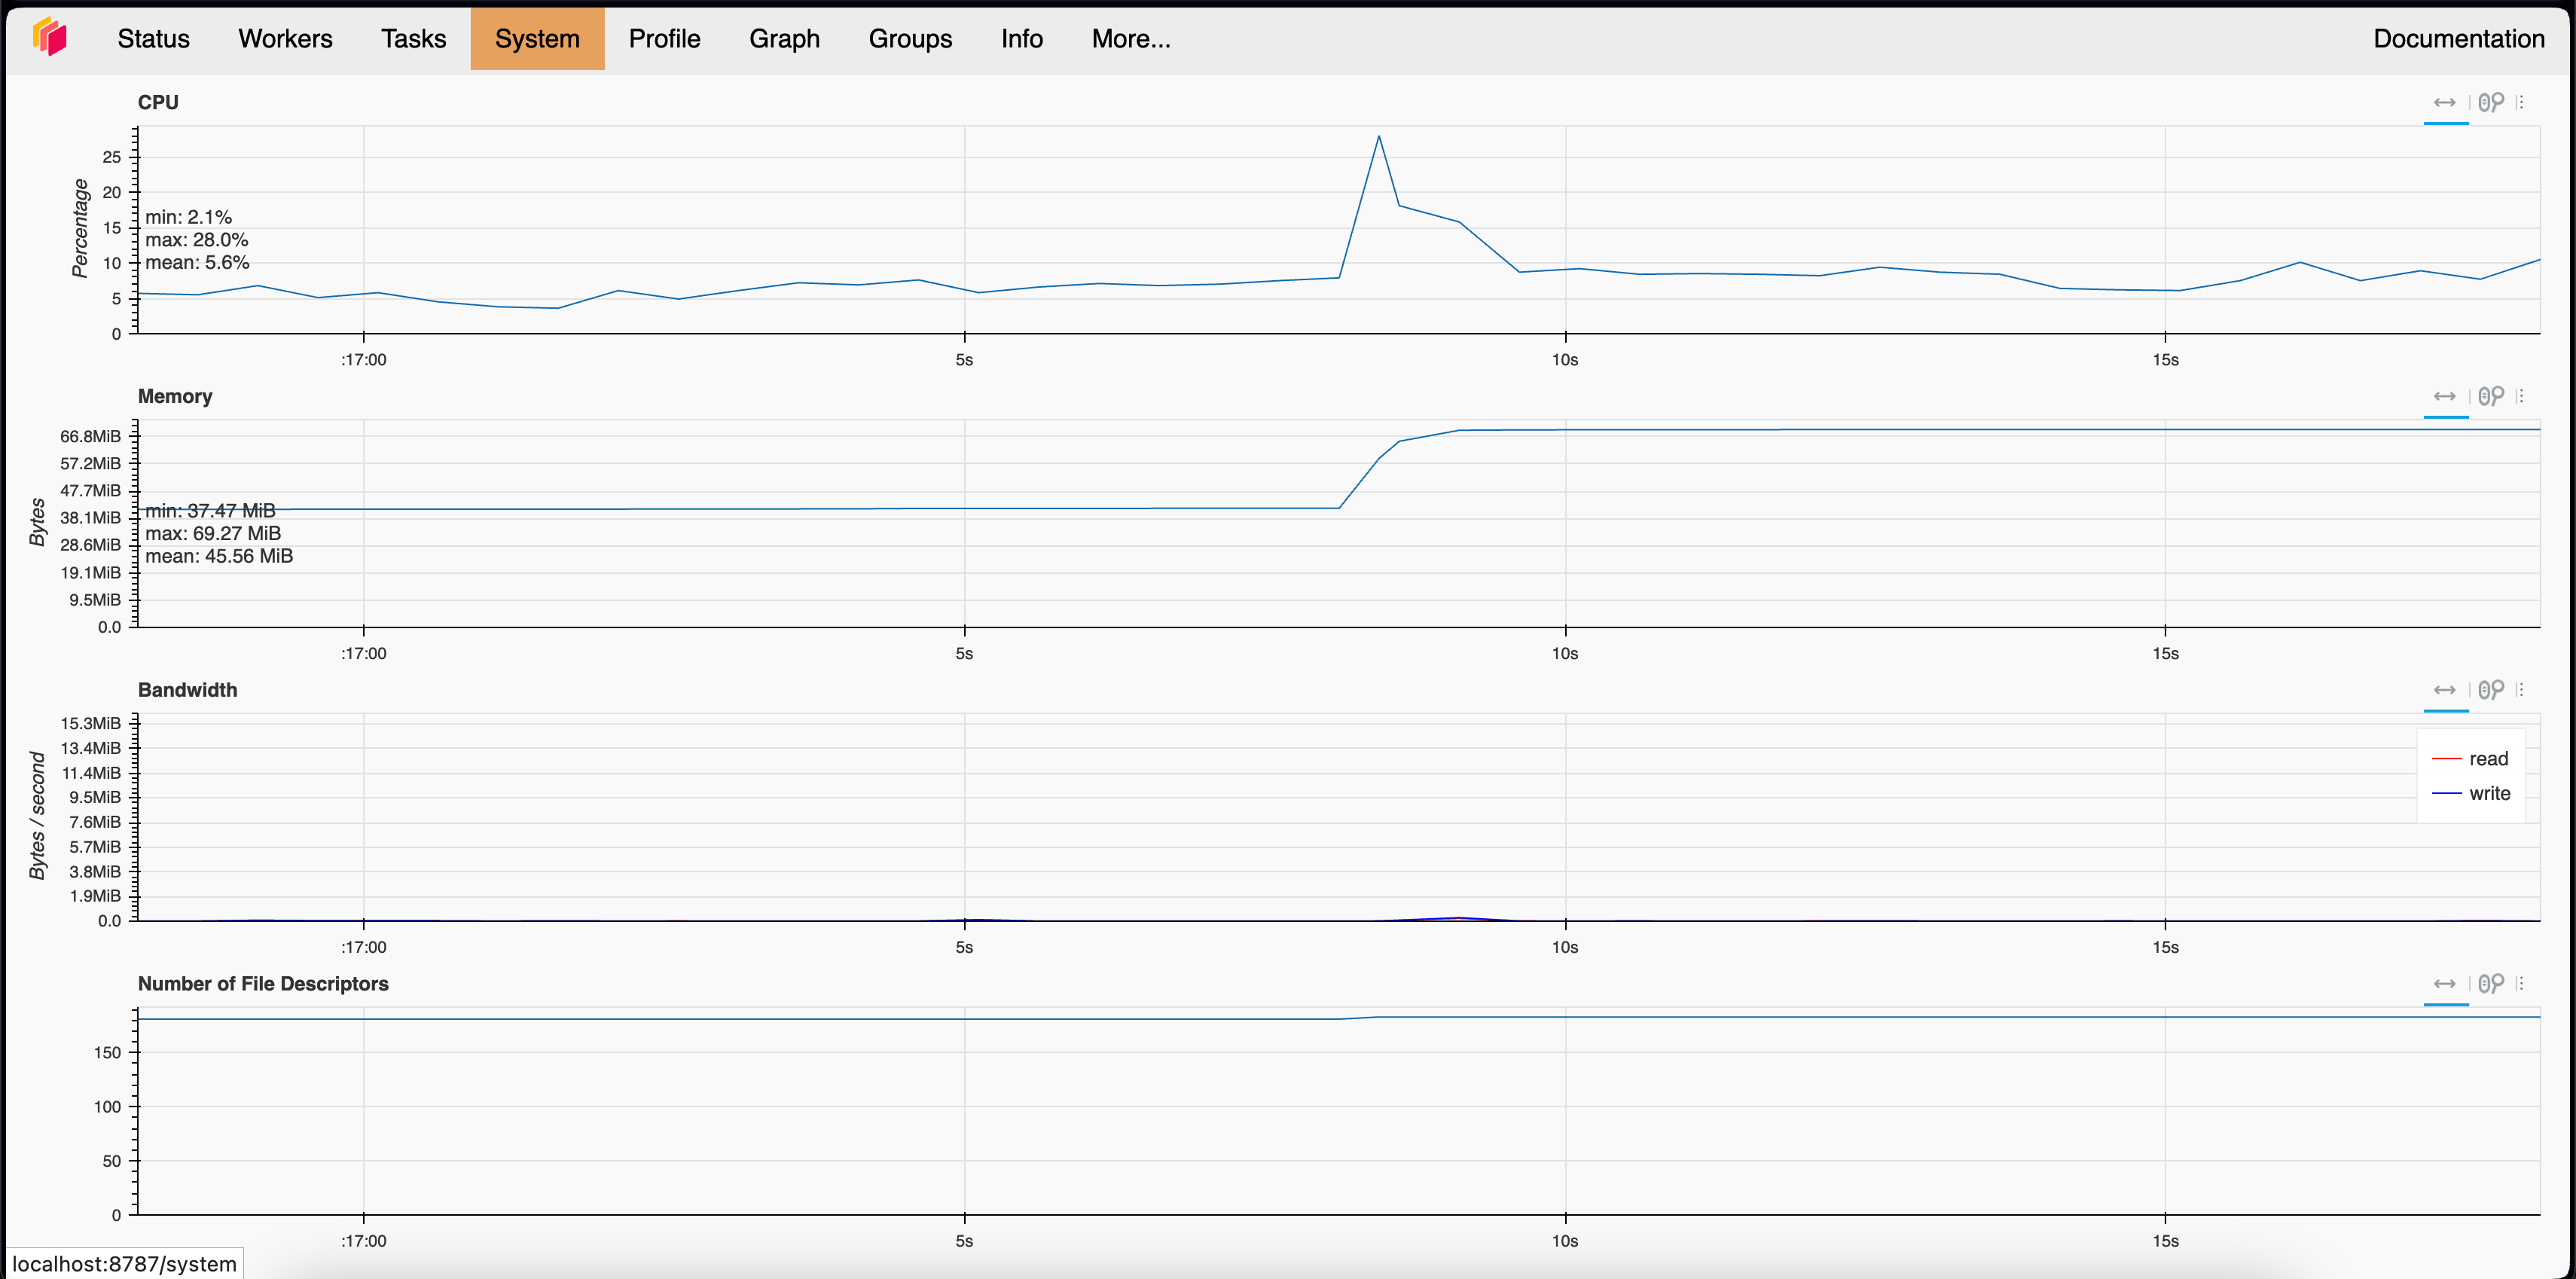

Это вкладка **System**, которая предоставляет информацию о системных ресурсах всего кластера Dask в реальном времени. Вот что показывают графики:

- **CPU**: Использование ЦПУ в процентах по всем рабочим узлам. Вы можете увидеть минимальное, максимальное и среднее использование ЦПУ за определенный период времени.

- **Memory**: Использование памяти в байтах по всем рабочим узлам. График показывает текущее использование памяти, а также минимальное, максимальное и среднее значения.

- **Bandwidth**: Показывает сетевую пропускную способность, используемую для чтения и записи данных (отображается в байтах в секунду). Красная линия указывает на сетевой ввод (чтение данных), а синяя — на сетевой вывод (запись данных).

- **Number of File Descriptors**: Количество открытых файловых дескрипторов на всех рабочих узлах.

Эти графики используются для мониторинга загрузки системных ресурсов кластера и могут помочь выявить проблемы с производительностью.

# Заключение

Преимущества, которые я смог выделить:

- **Легкость интеграции**: Dask легко интегрируется с существующими научными и аналитическими рабочими процессами благодаря совместимости с популярными библиотеками Python, такими как Pandas, NumPy и Scikit-Learn.

- **Масштабируемость**: Dask способен масштабироваться от одиночных машин до кластеров, обеспечивая гибкость в использовании вычислительных ресурсов. У меня не было возможности протестировать с несколькими машинами, но уверен, что вычисления ускоряются в таком случае многократно

- **Параллелизм**: Dask позволяет прозрачно использовать многопоточность и многопроцессорность, облегчая выполнение параллельных вычислений.

- **Динамическое** выполнение: Dask динамически оптимизирует и выполняет вычислительные графы, что позволяет эффективно управлять зависимостями и распределением задач.

- **Интерактивность**: Интерактивный мониторинг выполнения задач через Dask Dashboard значительно упрощает отладку и оптимизацию кода.

- **Оптимизация**: Через дашборд можно отслеживать использование памяти, ЦПУ и сетевой активности, что помогает в оптимизации производительности распределенных вычислений.


Таким образом, Dask представляет собой мощный инструмент для параллельных и распределённых вычислений в Python, который позволяет эффективно работать с большими объемами данных. С помощью Dask можно преодолеть ограничения, связанные с объемом оперативной памяти, и реализовать масштабируемые аналитические решения. Dask предлагает высокоуровневые структуры данных, такие как Dask DataFrame и Dask Array, которые аналогичны соответствующим структурам данных в библиотеках Pandas и NumPy, но при этом ориентированы на параллельную обработку.

In [18]:
# Для завершения работы кластера можете раскомментировать, когда закончите работу с тетрадкой

# client.close()